In [104]:
import re
import string
from unicodedata import normalize

import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

import random
import gensim
import pandas as pd
import spacy
from gensim import corpora
from gensim import models
from gensim.models import CoherenceModel
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
import numpy as np

In [105]:
nlp = spacy.load('es_core_news_sm')

In [106]:
stemmer = SnowballStemmer("spanish")

In [107]:
esp_stop = stopwords.words('spanish')
esp_stop.remove('estado')

In [108]:
def lemmatizer(text):
  doc = nlp(text)
  return ' '.join([stemmer.stem(word.lemma_) for word in doc if word.lemma_ not in esp_stop])

In [109]:
def preprocess(df, column):
  articles = df

  articles[column] = articles[column].str.translate(str.maketrans(' ', ' ', string.punctuation))
  articles[column] = articles[column].str.strip()
  articles[column] = articles[column].str.replace('\n', ' ')
  articles[column] = articles[column].str.replace('nº', ' ')
  articles[column] = articles[column].str.translate(str.maketrans(' ', ' ', string.punctuation))
  articles[column] = articles[column].apply(lambda x: " ".join(x.split()))
  articles[column] = articles[column].apply(lambda x: re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", normalize("NFD", x), 0, re.I))

  articles = articles[[len(str(x).split()) > 2 for x in articles[column]]]
  return articles.reset_index(drop=True)

### Apertura archivo y preprocesamiento

In [110]:
with open("data/nc_ch_articles.txt", "r") as file:
    data = file.read()
    data = data.replace("\n", " ")
    data = re.sub("\d+", "", data)
    data = data.lower()
    list_art = data.split("--articulo--")

In [111]:
df_art = pd.DataFrame(list_art, columns = ["article"])

In [112]:
df_art_p = preprocess(df_art, "article")

In [113]:
corpus = [word_tokenize(lemmatizer(i)) for i in df_art_p["article"]]

In [114]:
dict_corpus = corpora.Dictionary(corpus)

dtm_gensim = [dict_corpus.doc2bow(i) for i in corpus]
dtm_gensim_tfidf = models.TfidfModel(dtm_gensim)[dtm_gensim]

In [115]:
ldamodel_gensim = gensim.models.ldamodel.LdaModel(
    corpus = dtm_gensim_tfidf,
    id2word = dict_corpus,
    random_state = 42,
    chunksize = 1000,
    passes = 10,
    alpha = 'auto'
)

In [140]:
ldamodel_gensim.print_topics(
    num_words = 20,
    num_topics = 5
)

[(24,
  '0.000*"consanguin" + 0.000*"habitual" + 0.000*"merit" + 0.000*"nombramient" + 0.000*"parient" + 0.000*"postul" + 0.000*"segund" + 0.000*"considerar" + 0.000*"definir" + 0.000*"modernizacion" + 0.000*"optimizacion" + 0.000*"agil" + 0.000*"capacitacion" + 0.000*"perfeccion" + 0.000*"predetermin" + 0.000*"candidat" + 0.000*"concurs" + 0.000*"cesacion" + 0.000*"cuart" + 0.000*"seleccion"'),
 (39,
  '0.000*"consanguin" + 0.000*"habitual" + 0.000*"merit" + 0.000*"nombramient" + 0.000*"parient" + 0.000*"postul" + 0.000*"segund" + 0.000*"considerar" + 0.000*"definir" + 0.000*"modernizacion" + 0.000*"optimizacion" + 0.000*"agil" + 0.000*"capacitacion" + 0.000*"perfeccion" + 0.000*"predetermin" + 0.000*"candidat" + 0.000*"concurs" + 0.000*"cesacion" + 0.000*"cuart" + 0.000*"seleccion"'),
 (70,
  '0.049*"territorial" + 0.042*"entid" + 0.038*"autonom" + 0.035*"territori" + 0.031*"comun" + 0.028*"naturalez" + 0.026*"autonomi" + 0.025*"desarroll" + 0.022*"regional" + 0.020*"fin" + 0.020*"pa

In [117]:
df_topic_term = pd.DataFrame(
    ldamodel_gensim.get_topics(),
    columns = ldamodel_gensim.id2word.values(),
    index = [f'topic{i}' for i in range(ldamodel_gensim.num_topics)]
)

In [118]:
df_topic_term.sort_values(by = df_topic_term.columns.values.tolist(), ascending = False)

,activ,asegur,bien,chil,colect,condicion,constitu,cultural,deb,democraci,...,quincuagesim,rebaj,rec,reclamacion,reclamar,reconstruccion,rev,tener,tipific,transitar
topic32,0.016425,0.002774,0.000140,0.000145,0.000140,0.000145,0.000140,0.000151,0.007763,0.000140,...,0.000140,0.000140,0.000140,0.000140,0.000140,0.000140,0.000140,0.000140,0.000140,0.000140
topic40,0.014690,0.000297,0.000297,0.000297,0.000297,0.000297,0.000297,0.000297,0.000313,0.000297,...,0.000297,0.000297,0.000297,0.000297,0.000297,0.000297,0.000297,0.000297,0.000297,0.000297
topic22,0.012881,0.000141,0.000137,0.000137,0.000137,0.000143,0.000145,0.000137,0.000149,0.000137,...,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137,0.000137
topic46,0.004390,0.000335,0.000335,0.000335,0.000335,0.000335,0.000335,0.000335,0.000344,0.000335,...,0.000335,0.000335,0.000335,0.000335,0.000335,0.000335,0.000335,0.000335,0.000335,0.000335
topic63,0.004276,0.000294,0.002864,0.000613,0.037497,0.000304,0.003769,0.000321,0.000266,0.003809,...,0.000254,0.000254,0.000254,0.000254,0.000254,0.000254,0.000254,0.000254,0.000254,0.000254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
topic12,0.000094,0.000093,0.000089,0.000093,0.000089,0.000089,0.000089,0.016993,0.000089,0.000089,...,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089
topic58,0.000072,0.000072,0.007322,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,...,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072
topic70,0.000064,0.000064,0.000064,0.011461,0.000064,0.000064,0.000064,0.012077,0.000064,0.000064,...,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064
topic17,0.000043,0.010573,0.000043,0.000043,0.000043,0.000046,0.000043,0.000043,0.000096,0.000043,...,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043


In [119]:
# Compute Coherence Score
'''
La Métrica de Coherencia nos da una idea de cómo de coherente es un modelo en cuanto a la distribución de sus topics: cuanto más distintas sean las palabras de los topics entre sí, menos relacionados estarán los topics y más coherente será el modelo.
'''
coherence_model_lda = CoherenceModel(model=ldamodel_gensim, texts=corpus, dictionary=dict_corpus, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Perplexity
'''
Por otro lado, la Perplejidad es una medida de cuánto se sorprende el modelo cuando se le añade datos que no había visto antes.
'''
print('\nPerplexity: ', ldamodel_gensim.log_perplexity(dtm_gensim_tfidf))  # a measure of how good the model is. lower the better.


Coherence Score:  0.4952332905901915

Perplexity:  -34.09091453511143


In [120]:
def get_max(doc):
    idx, l = zip(*doc)
    return idx[np.argmax(l)] , l[np.argmax(l)]

tpc = [get_max(doc) for doc in ldamodel_gensim[dtm_gensim_tfidf]]
df_tpc = pd.DataFrame(tpc, columns =['topico', 'prop'])
df_tpc['doc'] = df_tpc.index
df_tpc[df_tpc["topico"]==1].sort_values('prop',ascending=False).head()

,topico,prop,doc


In [121]:
df_tpc.sort_values('prop',ascending=False).head()

,topico,prop,doc
294,11,0.794568,294
160,17,0.765610,160
29,17,0.757240,29
363,8,0.749127,363
44,12,0.703613,44


In [122]:
df_art_p['article'][24]

'toda persona tiene derecho a la igualdad que comprende la igualdad sustantiva la igualdad ante la ley y la no discriminacion es deber del estado asegurar la igualdad de trato y oportunidades en chile no hay persona ni grupo privilegiado queda prohibida toda forma de esclavitud el estado garantiza a todas las personas la igualdad sustantiva en tanto garantia del reconocimiento goce y ejercicio de los derechos fundamentales con pleno respeto a la diversidad la inclusion social y la integracion el estado asegura la igualdad de genero para las mujeres niñas diversidades y disidencias sexuales y de genero tanto en el ambito publico como privado esta prohibida toda forma de discriminacion en especial cuando se funde en uno o mas motivos tales como nacionalidad o apatridia edad sexo caracteristicas sexuales orientacion sexual o afectiva identidad y expresion de genero diversidad corporal religion o creencia raza pertenencia a un pueblo y nacion indigena o tribal opiniones politicas o de otr

In [123]:
def word_cloud_by_topic(i):
    plt.figure()
    plt.imshow(
        WordCloud(
            background_color = 'white',
            prefer_horizontal = 1.0
        ).fit_words(dict(ldamodel_gensim.show_topic(i, 20)))
    )
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()

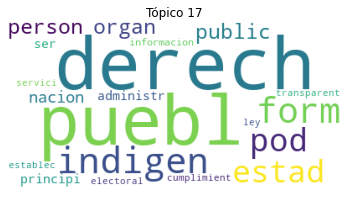

In [124]:
word_cloud_by_topic(17)

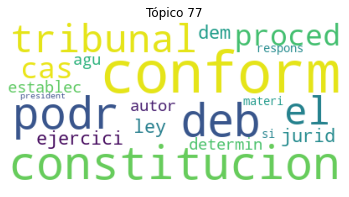

In [125]:
word_cloud_by_topic(77)

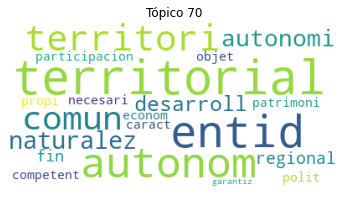

In [137]:
word_cloud_by_topic(70)

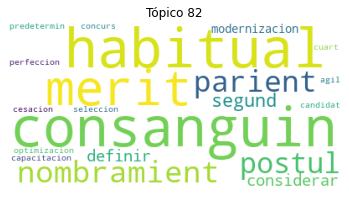

In [138]:
word_cloud_by_topic(82)

In [127]:
index_article = random.randint(0, len(df_art_p))
df_art_p.iloc[index_article]

article    se podran someter a referendum las materias de...
Name: 155, dtype: object

In [128]:
dist_indices = [topic[0] for topic in ldamodel_gensim[dtm_gensim[index_article]]]
dist_contrib = [topic[1] for topic in ldamodel_gensim[dtm_gensim[index_article]]]

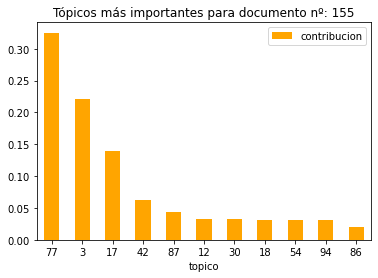

In [129]:
distribucion_topicos = pd.DataFrame({'topico':dist_indices,'contribucion':dist_contrib })
distribucion_topicos.sort_values('contribucion', ascending=False, inplace=True)

ax = distribucion_topicos.plot.bar(
    y='contribucion',
    x='topico',
    rot=0,
    color="orange",
    title = "Tópicos más importantes para documento nº: " + str(index_article)
)

In [130]:
for ind, topico in distribucion_topicos.iterrows():
    print("Topico: " + str(int(topico.topico)))
    palabras = ', '.join([palabra[0] for palabra in ldamodel_gensim.show_topic(topicid=int(topico.topico))])
    print(palabras, "\n")

Topico: 77
conform, constitucion, deb, podr, tribunal, el, proced, cas, ejercici, dem 

Topico: 3
regional, region, cuent, integracion, asamble, represent, deber, diput, facult, popul 

Topico: 17
derech, puebl, indigen, form, pod, estad, public, organ, person, nacion 

Topico: 42
central, regul, promov, cad, banc, legisl, consult, organizacion, medioambient, instrument 

Topico: 87
espaci, cient, conocer, institucional, resolver, minim, cincuent, condicion, transversal, alcanz 

Topico: 12
trabaj, derech, medi, ten, trav, person, segur, social, financi, ident 

Topico: 30
civil, san, remuner, tribunal, calif, regional, escrutini, electoral, convivient, conyug 

Topico: 18
estatut, ejecut, implement, asamble, regional, celebr, prepar, conveni, autonom, manej 

Topico: 54
gobiern, dirig, extrajudicial, obten, vot, mayori, mas, valid, producir, intermediacion 

Topico: 94
reform, propuest, referendum, aprob, derog, nuev, promulgacion, derogacion, vigenci, publicacion 

Topico: 86
vid, ch